In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

# How computers Make Predictions

Consider the 1D advection equation:

\begin{equation}
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0
\end{equation}

Here $u(x, t)$ is a function of space and time that satisfies this equation and $a$ is a constant.

For simplicity let's assume that this function is defined on the domain $0 < x < L$ and that $u(x, t=0)$ is a gaussian function centered at $L/2$. Let's also *discretize* the domain into chunks of width $\Delta x = L/M$ where M is a large integer. For now, let's choose $M=1000$, $L=1$, and $a = 0.1$.

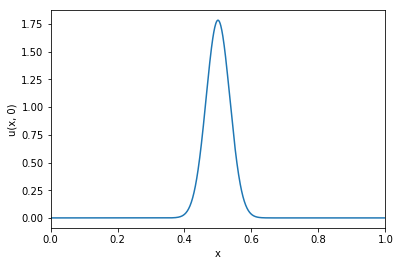

In [2]:
M = 1000
L = 1
a = 0.1
x = np.linspace(0, L, M)
dx = L/(M-1)
dt = .01

sigma = .05
mu = L/2

u = 1/np.sqrt(2*np.pi*sigma)*np.exp(-((x - mu)/sigma)**2)

def uplot(x, u, t):
    plt.plot(x, u)
    plt.xlim(0, 1)
    plt.xlabel('x')
    plt.ylabel('u(x, %g)' % t)
    plt.show()

uplot(x, u, 0)

It turns out that the solution to the differential equation we'd like to solve is:

\begin{equation}
u(x, t) = u_0(x - at)
\end{equation}

Where $u_0(x) = u(x, 0)$ is the initial conditions. You can verify that this is the solution by plugging into the equation we started with and making use of the chain rule.

The solution at $t=0$ gets *advected* to the right at velocity $a$:



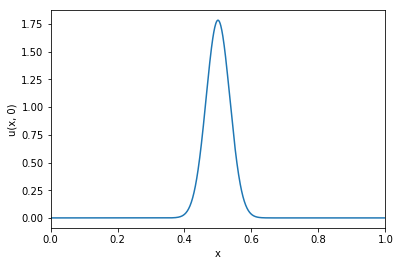

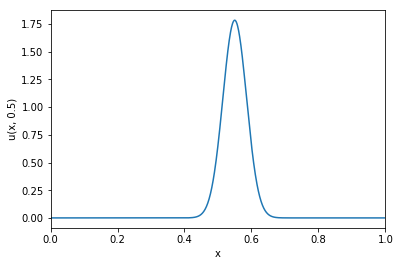

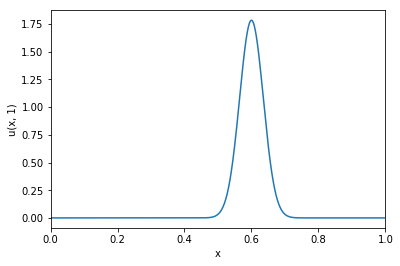

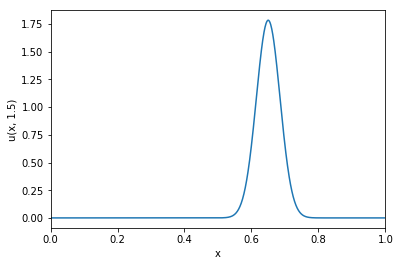

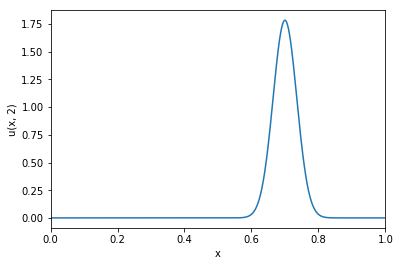

In [3]:
for t in np.linspace(0, 2, 5):
    u = 1/np.sqrt(2*np.pi*sigma)*np.exp(-(((x - t*a) - mu)/sigma)**2)

    uplot(x, u, t)

# Numerical Solution

How do we go about solving this on a computer?

As we've already shown, we can *discretize* the domain to approximately represent the solution in a finite amount of memory.

In particular, let's define the following notation:

\begin{equation}
u^n_j = u(j\cdot\Delta x, n\cdot\Delta t)
\end{equation}

That is, the symbol $u^n_j$ represents the value of the solution for $u$ at a time $n$ time steps in the future and at a location $j$ cell spacings along the grid.

This allows us to rewrite the equation we started with in terms of **finite differences**. Let's start with the advection equation:

\begin{equation}
\frac{\partial u}{\partial t} + a \frac{\partial u}{\partial x} = 0
\end{equation}

We can get approximate results for the the partial derivatives in this equation by writing them as finite differences. In particular, I'm going to choose a difference scheme that is forward in time and centered in space, an FTCS method:

\begin{equation}
\frac{u^{n+1}_j - u^n_j}{\Delta t} + a \frac{u^{n}_{j+1} - u^{n}_{j - 1}}{2\Delta x} = 0
\end{equation}

If we are at time $n \cdot \Delta t$, we know the value of $u$, so $u_j^n$ is known for all $j$. That means that everything in the above equation is known except for $u^{n+1}{j}$. Therefore we can rearrange to find:

\begin{equation}
u_j^{n+1} = u_j^n - \frac{a \Delta t}{2\Delta x}\left(u_{j+1}^n - u_{j-1}^n \right)
\end{equation}

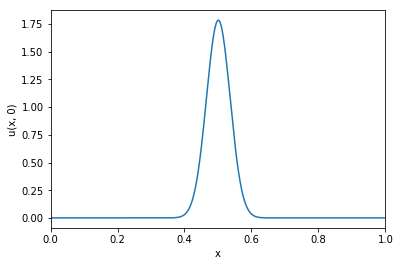

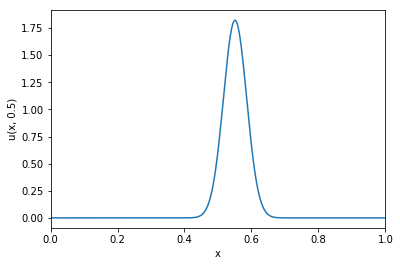

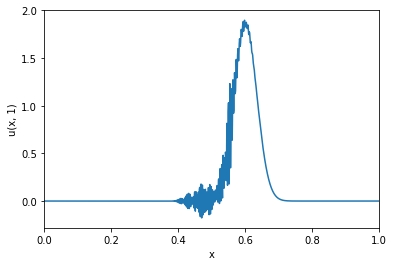

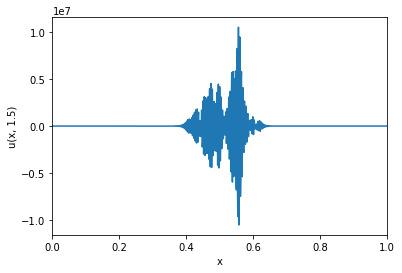

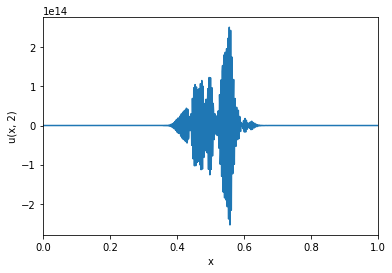

In [4]:
u = 1/np.sqrt(2*np.pi*sigma)*np.exp(-((x - mu)/sigma)**2)

def evolve(u):
    unew = np.zeros_like(u)
    for i in range(M-1):
        unew[i] = u[i] - a*dt/(2*dx)*(u[i+1] - u[i-1])
    return unew
        
for j in range(201):
    u = evolve(u)
    if j % 50 == 0:
        uplot(x, u, j*dt)

Uh-oh, something weird hapenned here. 

It turns out that the numerical scheme we designed here is *unstable*.

How could we have predicted that?

# Von Neumann Stability Analysis

This technique is based on the Fourier method. In this approach, we decompose the solution $u(x, t)$ into two terms, an (unknown) exact solution and an error term. The solution is unstable if the error term grows with time.

\begin{equation}
u(x, t) = u_{\rm{exact}}(x, t) + E(x, t)
\end{equation}

We know that the exact solution, $u_{\rm{exact}}$ should obey our descretized solution exactly, (after all we derived out descretization assuming the error is zero). The error term on the other hand *does not* exactly satisfy our descritization and we would like to know exactly how much. To do this, let's write the error as a Fourier sum:

\begin{equation}
E(x, t) = \sum_{m=0}^{\infty} r(t) e^{i k_m x}
\end{equation}

Where $r(t)$ is a function of time alone and $k_m = 2\pi L/m$ is the wave number for mode $m$. Let's try and understand the behavior of a single term in this sum, from which we will try to extract general results for the full sum. For this purpose it will help to note the following identities. For the error at $x=j\Delta x$ and at $t = n\Delta t$, we have:

\begin{equation}
E_j^n = r^n e^{i k j\Delta x} 
\end{equation}

Similarly:

\begin{align}
E_{j+1}^n &= r^n e^{i k (j+1)\Delta x} \\
E_{j}^{n+1} &= r^{n+1} e^{i k j\Delta x} \\
E_{j+1}^{n+1} &= r^{n+1} e^{i k (j+1)\Delta x}
\end{align}

Where $r^{n} = r(n\Delta t)$.

Plugging these into our finite difference formula yields the following result:

\begin{align}
E_j^{n+1} &= E_j^n - a \frac{\Delta t}{2\Delta x}(E_{j+1}^n - E_{j-1}^n) \\
r^{n+1} e^{i k_m j\Delta x} &= r^n e^{i k_m j\Delta x} - a \frac{\Delta t}{2\Delta x}(r^n e^{i k_m (j+1) \Delta x} - r^n e^{i k_m (j-1) \Delta x})
\end{align}

Dividing through by $r^n e^{i k_m j\Delta x}$, we find:

\begin{align}
r^{n+1}/r^{n} = 1 - a \frac{\Delta t}{2\Delta x}(e^{i k_m \Delta x} - e^{-i k_m \Delta x})
\end{align}

This ratio is known as the Growth Factor, $G(k)$. If $G(k) > 1$ then the solution is guaranteed to increase in amplitude with time and therefore the numerical method is unstable. We can see that this is the case for our FTCS method by noting that the right hand side can be simplified using a trigonometric identity:

\begin{equation}
G(k) = 1 + \frac{ia\Delta t}{\Delta x} \sin{k\Delta x}
\end{equation}

So,

\begin{equation}
|G(k)|^2 = 1 + \frac{a^2 \Delta t^2}{\Delta x^2} \sin^2{k \Delta x}
\end{equation}

Which we can immediately see is unconditionally greater than 1. Therefore the FTCS method is unconditionally unstable.

We can obtain a stable method if we replace $u^n_j$ on the right hand side of our finite difference scheme with the spatial average of the neighboring zones:

\begin{equation}
u_j^{n+1} = \frac{1}{2}\left(u_{j+1}^n + u_{j-1}^n \right) + \frac{a \Delta t}{2\Delta x}\left(u_{j+1}^n - u_{j-1}^n \right)
\end{equation}

If we make the same Von Neumann analysis, we find that the growth factor for *this* scheme is:

\begin{equation}
|G(k)|^2 = 1 - \left(1 - \left(\frac{a \Delta t}{\Delta x}\right)^2\right)\sin^2{k \Delta x}
\end{equation}

This is guaranteed to always be less than or equal to one if $1 - \frac{a \Delta t}{\Delta x} > 0$, or if

\begin{equation}
\frac{a \Delta t}{\Delta x} \le 1
\end{equation}

Rearranging, we have:

\begin{equation}
a \le \frac{\Delta x}{\Delta t}
\end{equation}

This is known as the Courant condition. All numerical schemes for the advection equation (and equations that admit wavelike solutions in general) have a corresponding Courant or Courant-like condition.

In this case, the condition implies that no signal should be able to propogate further along the grid than a single cell spacing in a single timestep.

Finally, let's see what this scheme looks like using our gaussian wave packet example:

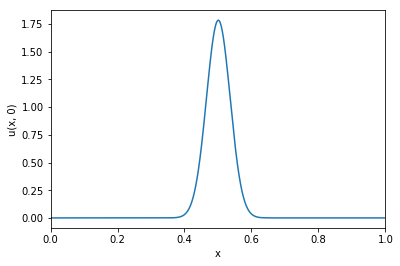

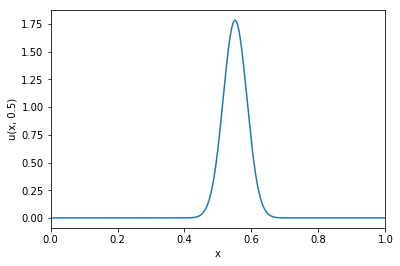

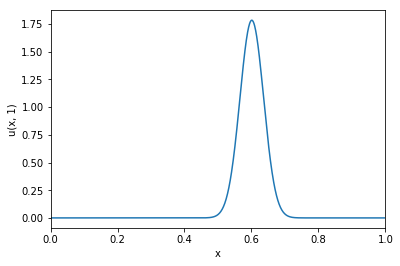

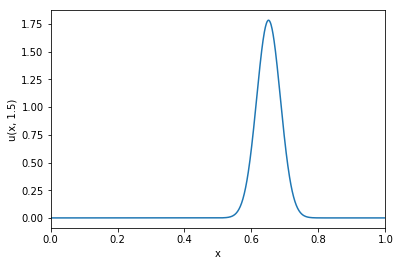

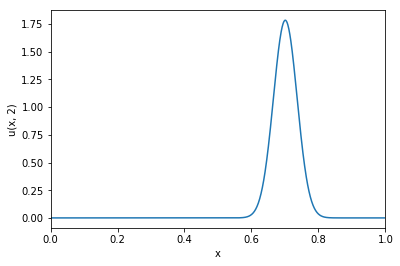

In [5]:
u = 1/np.sqrt(2*np.pi*sigma)*np.exp(-((x - mu)/sigma)**2)

def evolve(u):
    unew = np.zeros_like(u)
    for i in range(M-1):
        unew[i] = 0.5*(u[i-1] + u[i+1]) - a*dt/(2*dx)*(u[i+1] - u[i-1])
    return unew
        
for j in range(201):
    u = evolve(u)
    if j % 50 == 0:
        uplot(x, u, j*dt)

We see that this approach is much more stable than the original approach.